# Sensitivity to variables included: 

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [3]:
import pickle as pickle

In [4]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [5]:
def plot_lagged_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin):

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][:]**2, 
               label='Correlation',linewidth=4)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
               label='AR(1) Correlation',linewidth=4, 
               linestyle='--', color='tab:blue',alpha=0.5)

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][:],
               label='CE',linewidth=3.0)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
               label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,1)
    axs.set_xlim(0,8)
    axs.grid(axis='both')
    
    return 

In [6]:
def plot_monthly_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gm_rmse'][:], 
               label='LIM',linewidth=3.0, color='purple')
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,0.018)
    axs.set_xlim(0,6)
    axs.grid(axis='both')
    
    axs.axhline(1.0, color='k', linewidth=2, label='No skill')
    
    return 

In [30]:
ntrunc=60 # EOF truncation for individual fields (reduced-state space)
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 60
#modes_sic = 20

mo='all'
#mo=0

model = 'cmip6_mpi_hist'

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars_list = [['sic'],
                ['tas','sic'],
                ['sit','sic'],
                ['tos','sic'],
                ['psl','sic'],
                ['tas','sit','sic'],
                ['tas','tos','sic'],
                ['tas','tos','sit','sic'],
                ['tas','tos','psl','sit','sic']]

'Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_2005_2014_'+(str(ntrunc)+"_").join(limvars_list[5])+str(nmodes_sic)+'_20211018.pkl'

'Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_2005_2014_tas60_sit60_sic60_20211018.pkl'

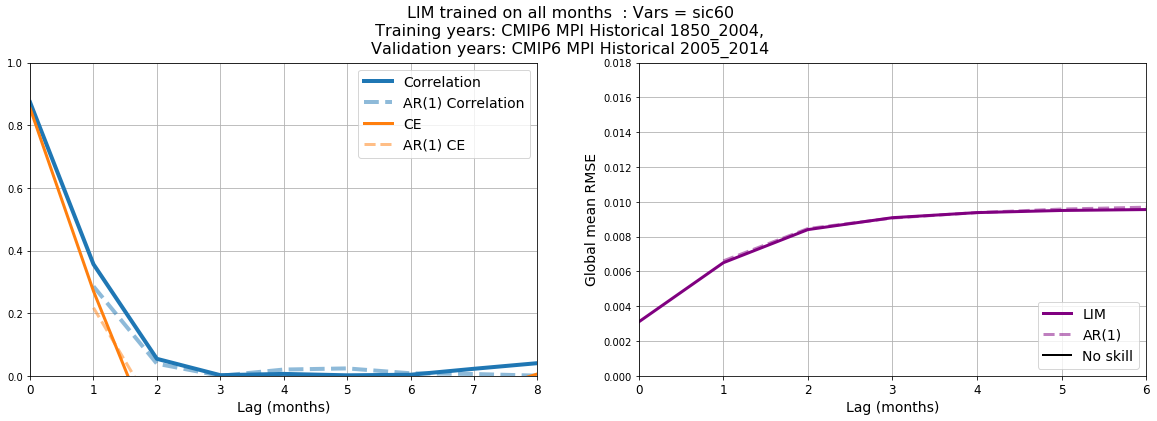

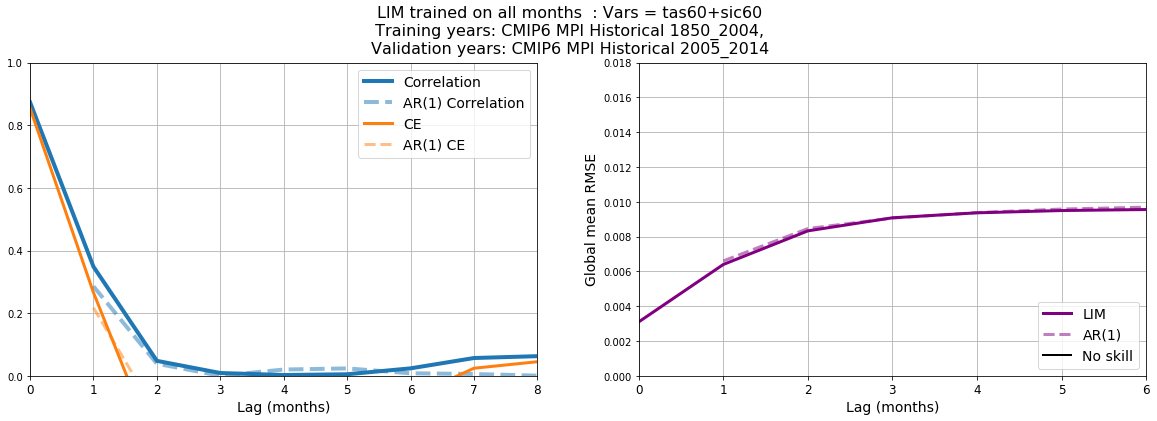

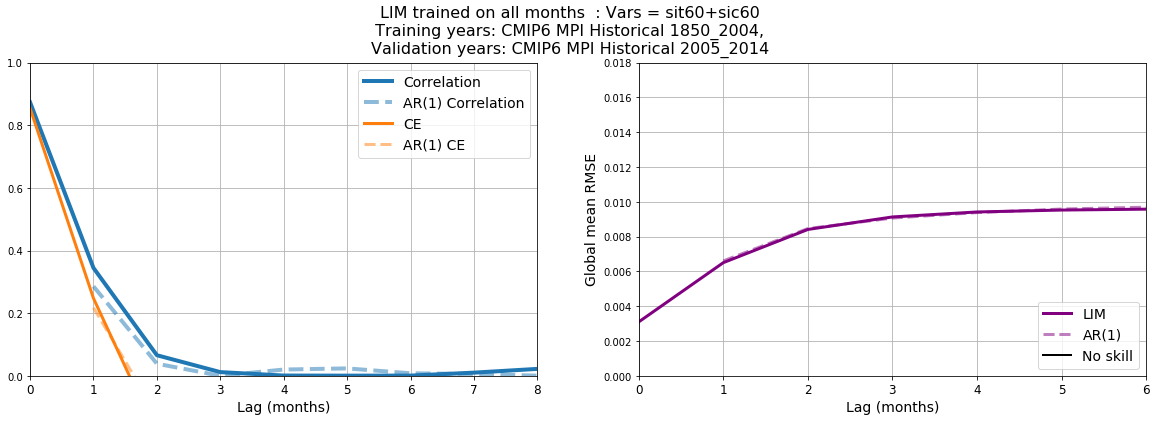

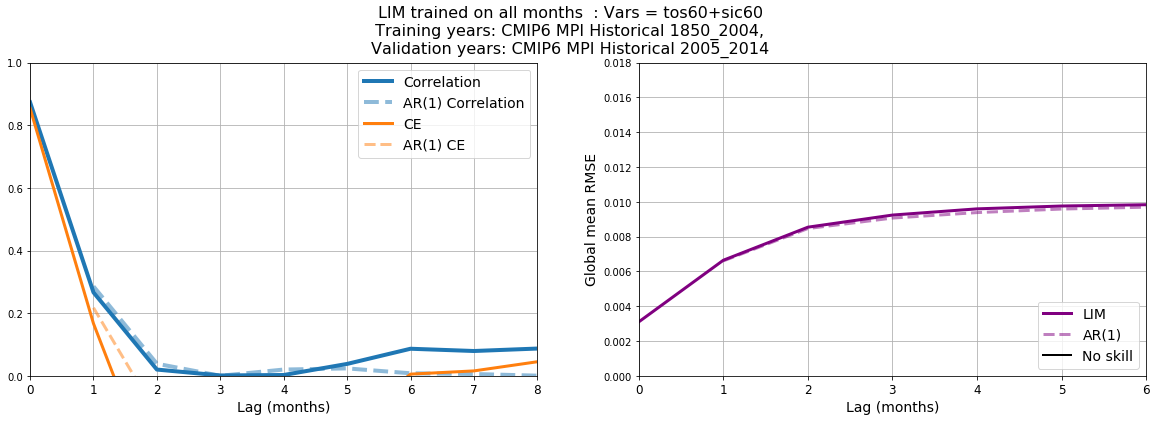

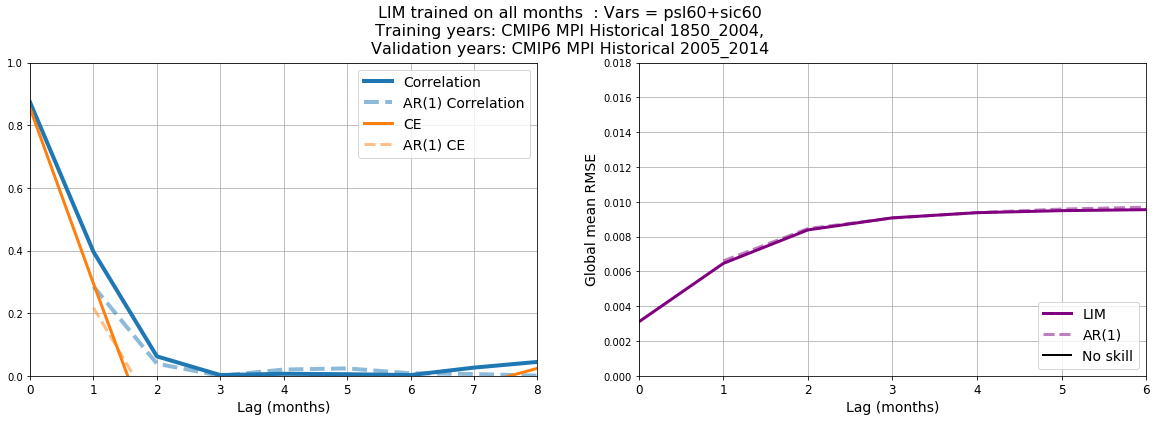

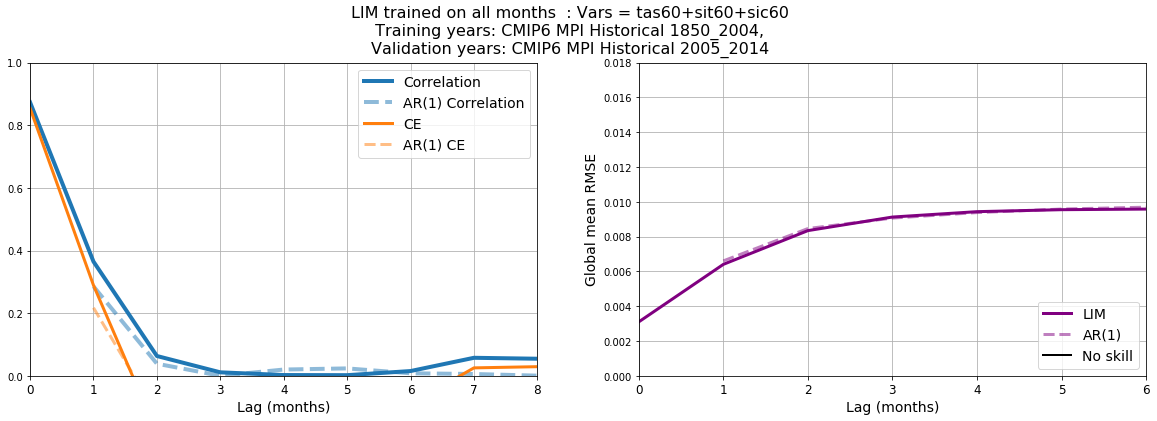

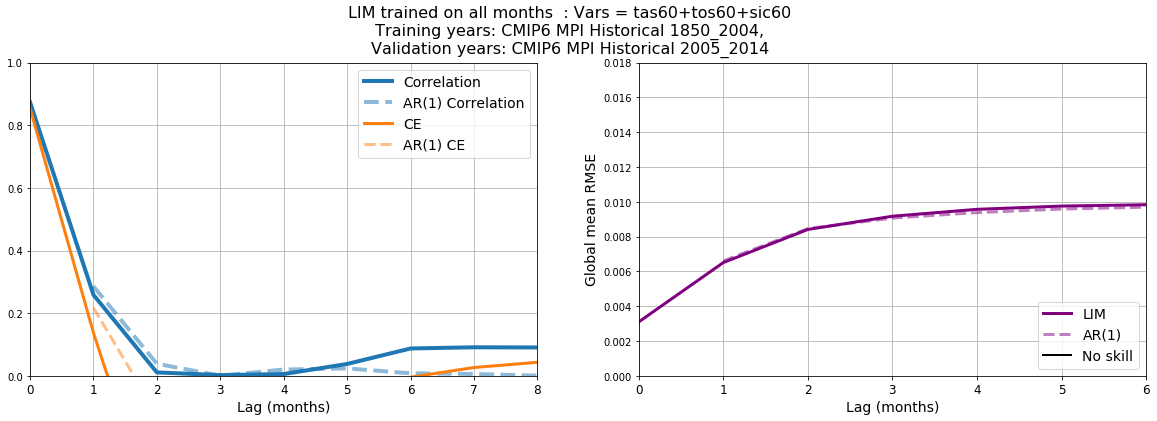

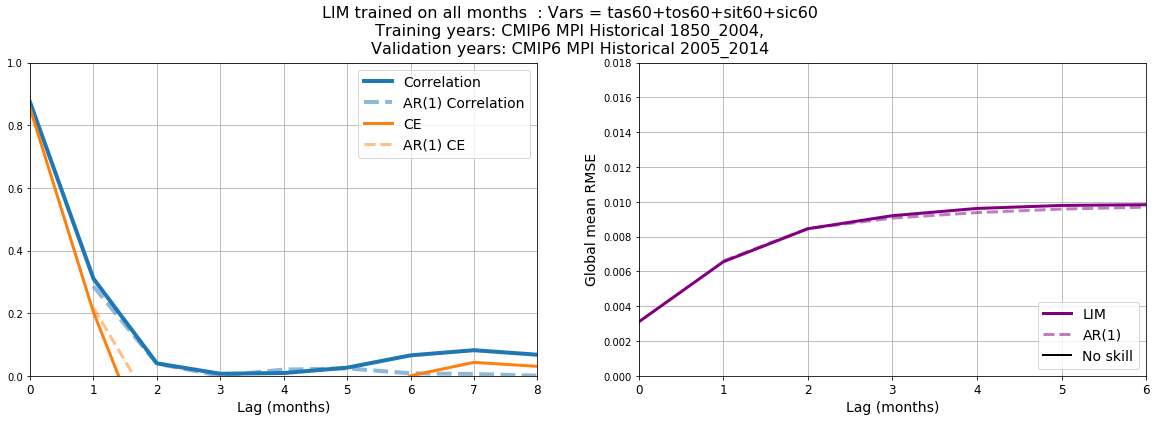

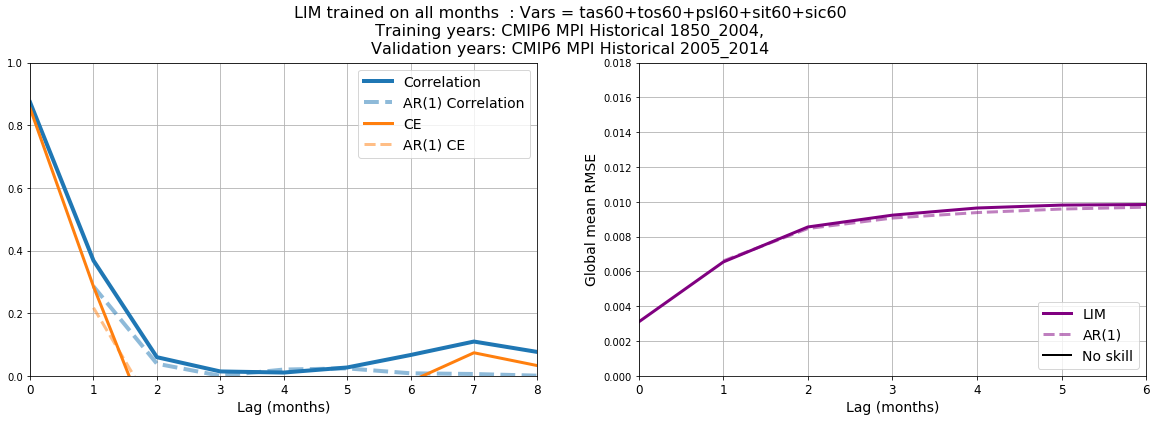

In [31]:
for n,limvars in enumerate(limvars_list):
    var = 'sic'
    exp_name = (str(ntrunc)+"+").join(limvars)+str(nmodes_sic)

    folder = 'historical/'
    filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_'+
                (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)+'_20211018.pkl')

    experiment =  pickle.load(open(folder+filename, 'rb'))
    
    exp_setup = experiment['forecast']['exp_setup']
    forecast = experiment['forecast']
    LIMd = experiment['LIMd']
    forecast_validation = experiment['forecast_validation']
    forecast_validation_lags = experiment['forecast_validation_lags']
    ar1cast = experiment['ar1cast']
    ar1cast_lags = experiment['ar1cast_lags']
    
    [tcmip, vcmip, valid_yrs_str, texp, 
     vexp, tmod, vmod, wt_addin, tr_addin] = get_title_strings(var,exp_setup,forecast)
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------
    
    fig,axs = plt.subplots(1,2,figsize=(20,6))
    
    ax = axs.flatten()

    plot_lagged_performance_1var(fig,ax[0],var,forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin)
    plot_monthly_performance_1var(fig,ax[1],var,forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin)
    

    if exp_setup['Insamp']==True:     
        plt.suptitle(('LIM trained on all months: Vars = '+exp_name+'\n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                     ', Validation years: Historical'), fontsize=16)
    else: 
        plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+': Vars = '+exp_name+'\n Training years: '+
                      tcmip+' '+tmod+' '+texp+' '+exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+
                      vcmip+' '+vmod+' '+vexp+' '+valid_yrs_str), fontsize=16)

    ax[0].legend(loc='upper right', fontsize=14)
    ax[0].set_xlabel('Lag (months)', fontsize=14)
    
    ax[1].legend(loc='lower right', fontsize=14)
    ax[1].set_xlabel('Lag (months)', fontsize=14)
    ax[1].set_ylabel('Global mean RMSE', fontsize=14)

    plt.subplots_adjust(top=0.85)

In [42]:
var = 'sic'
n = 0 
limvars = ['sic']
exp_name = (str(ntrunc)+"+").join(limvars)+str(nmodes_sic)

folder = 'historical/'
# filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_'+
#             (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)+'_20211018.pkl')
filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_'+
            (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)+'_20211019.pkl')

experiment =  pickle.load(open(folder+filename, 'rb'))

LIMd = experiment['LIMd']
forecast_validation_lags = experiment['forecast_validation_lags']

In [43]:
corr_baseline = forecast_validation_lags['validation_stats_lags']['sic']['corr_tot']
ce_baseline = forecast_validation_lags['validation_stats_lags']['sic']['ce_tot']
rmse_baseline = forecast_validation_lags['validation_stats_lags']['sic']['gm_rmse']

lam_L_baseline = LIMd['lam_L']

In [44]:
colors = ['royalblue','purple', 'c', 'orange', 'green','navy','sienna','grey','k']

Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_tas60_sic60_20211019.pkl
Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_sit60_sic60_20211019.pkl
Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_tos60_sic60_20211019.pkl
Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_psl60_sic60_20211019.pkl


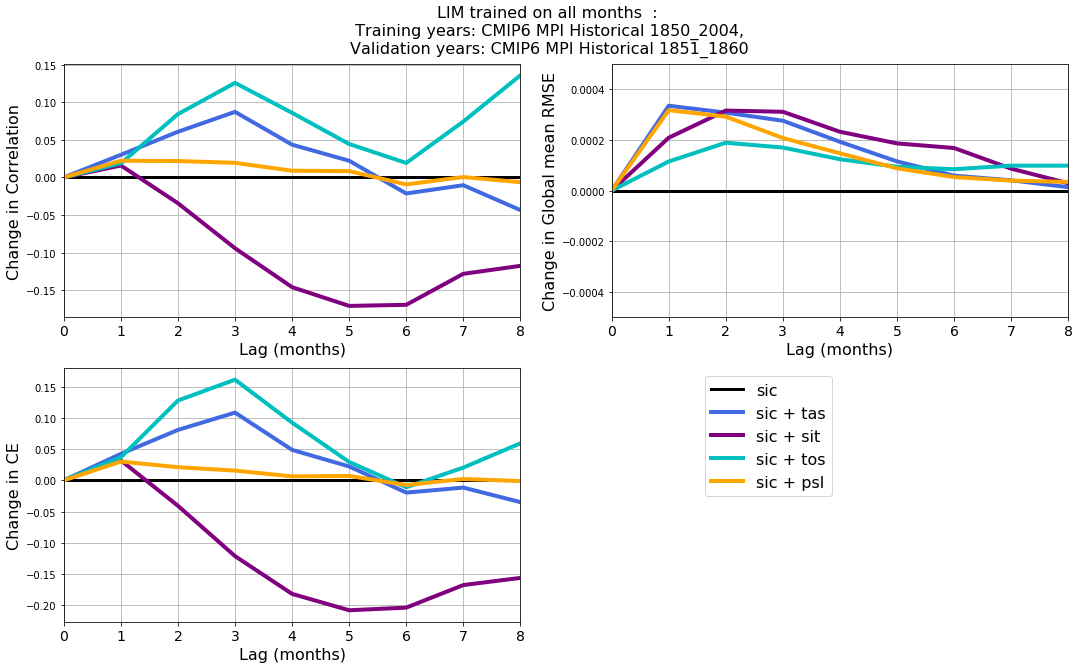

In [45]:
fig,axs = plt.subplots(2,2,figsize=(18,10))
ax = axs.flatten()

ax[0].axhline(0.0, color='k', linewidth=3, label='sic')
ax[1].axhline(0.0, color='k', linewidth=3, label='sic')
ax[2].axhline(0.0, color='k', linewidth=3, label='sic')

for n,limvars in enumerate(limvars_list[1:5]):
    var = 'sic'
    exp_name = "sic + "+(" + ").join(limvars[:-1])#+str(nmodes_sic)

    folder = 'historical/'
#     filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_'+
#                 (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)+'_20211018.pkl')
    filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_'+
                (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)+'_20211019.pkl')
    
    print('Loading '+folder+filename)

    experiment =  pickle.load(open(folder+filename, 'rb'))
    
    exp_setup = experiment['forecast']['exp_setup']
    forecast = experiment['forecast']
    LIMd = experiment['LIMd']
    forecast_validation = experiment['forecast_validation']
    forecast_validation_lags = experiment['forecast_validation_lags']
    ar1cast = experiment['ar1cast']
    ar1cast_lags = experiment['ar1cast_lags']
    
    [tcmip, vcmip, valid_yrs_str, texp, 
     vexp, tmod, vmod, wt_addin, tr_addin] = get_title_strings(var,exp_setup,forecast)
    
    corr_diff = forecast_validation_lags['validation_stats_lags'][var]['corr_tot'] - corr_baseline
    ce_diff = forecast_validation_lags['validation_stats_lags'][var]['ce_tot'] -  ce_baseline
    rmse_diff = rmse_baseline - forecast_validation_lags['validation_stats_lags'][var]['gm_rmse']
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

    ax[0].plot(exp_setup['lags'][:],corr_diff,label=(exp_name),linewidth=4.0, color=colors[n])
    ax[2].plot(exp_setup['lags'][:],ce_diff,linewidth=4.0, label=(exp_name),color=colors[n])
    ax[1].plot(exp_setup['lags'][:],rmse_diff,label=(exp_name),linewidth=4.0, color=colors[n])
    

ax[1].set_xticklabels(np.arange(0,18,1),fontsize=14)
#ax[1].set_yticklabels(np.arange(-0.00041,0.00041,0.0002),fontsize=14)
ax[1].set_ylim(-0.0005,0.0005)
ax[1].set_xlim(0,8)
ax[1].grid(axis='both')

# ax[0].set_xticks(np.arange(0,8,1))
ax[0].set_xticklabels(np.arange(0,18,1),fontsize=14)
#ax[0].set_yticklabels(np.arange(-0.21,0.21,0.1),fontsize=14)
#ax[0].set_ylim(-0.25,0.25)
ax[0].set_xlim(0,8)
ax[0].grid(axis='both')

ax[2].set_xticklabels(np.arange(0,18,1),fontsize=14)
#ax[2].set_yticklabels(np.arange(-0.21,0.21,0.1),fontsize=14)
#ax[2].set_ylim(-0.25,0.25)
ax[2].set_xlim(0,8)
ax[2].grid(axis='both')

# ax[3].xaxis.set_visible(False) 
# ax[3].yaxis.set_visible(False)
ax[3].axis('off')
    
if exp_setup['Insamp']==True:     
    plt.suptitle(('LIM trained on all months:\n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else: 
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+': \n Training years: '+
                  tcmip+' '+tmod+' '+texp+' '+exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+
                  vcmip+' '+vmod+' '+vexp+' '+valid_yrs_str), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Change in Correlation', fontsize=16)

ax[2].set_xlabel('Lag (months)', fontsize=16)
ax[2].set_ylabel('Change in CE', fontsize=16)

#ax[3].legend(loc='upper left', fontsize=14)
ax[2].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)
ax[1].set_xlabel('Lag (months)', fontsize=16)
ax[1].set_ylabel('Change in Global mean RMSE', fontsize=16)

plt.subplots_adjust(top=0.90)

In [167]:
var = 'sic'
n = 0 
limvars = ['tos','sic']
exp_name = (str(ntrunc)+"+").join(limvars)+str(nmodes_sic)

folder = 'historical/'
# filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_'+
#             (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)+'_20211018.pkl')
filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_'+
            (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)+'_20211019.pkl')

experiment2 =  pickle.load(open(folder+filename, 'rb'))

forecast_validation_lags2 = experiment2['forecast_validation_lags']
exp_setup = experiment2['forecast']['exp_setup']

In [168]:
corr_baseline2 = forecast_validation_lags2['validation_stats_lags']['sic']['corr_tot']
ce_baseline2 = forecast_validation_lags2['validation_stats_lags']['sic']['ce_tot']
rmse_baseline2 = forecast_validation_lags2['validation_stats_lags']['sic']['gm_rmse']

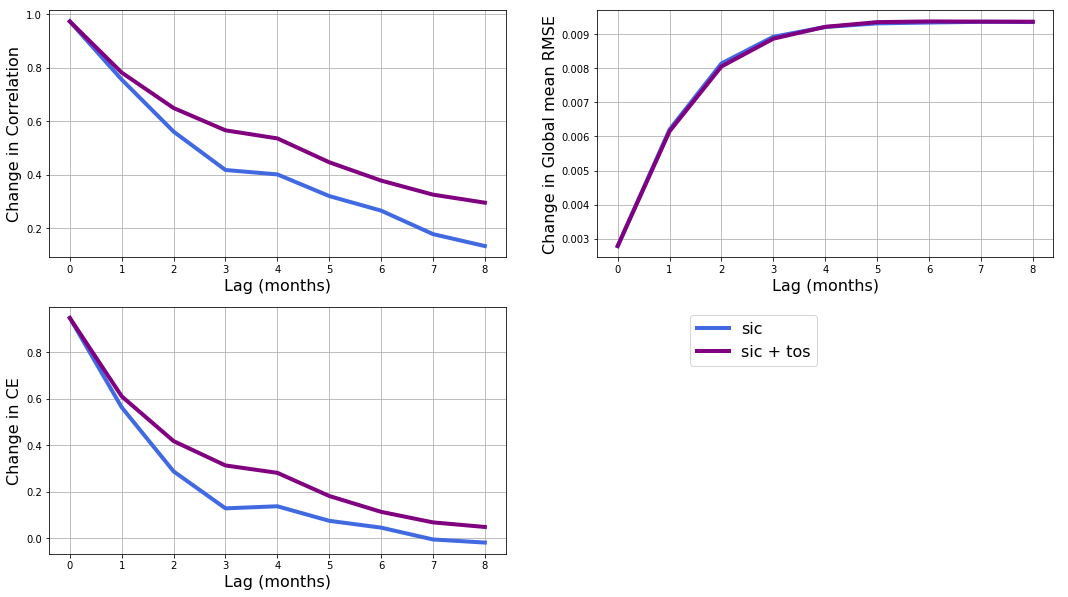

In [174]:
fig,axs = plt.subplots(2,2,figsize=(18,10))
ax = axs.flatten()

ax[0].plot(exp_setup['lags'][:],corr_baseline,label=('sic'),linewidth=4.0, color=colors[0])
ax[2].plot(exp_setup['lags'][:],ce_baseline,linewidth=4.0, label=('sic'),color=colors[0])
ax[1].plot(exp_setup['lags'][:],rmse_baseline,label=('sic'),linewidth=4.0, color=colors[0])

ax[0].plot(exp_setup['lags'][:],corr_baseline2,label=('sic + tos'),linewidth=4.0, color=colors[1])
ax[2].plot(exp_setup['lags'][:],ce_baseline2,linewidth=4.0, label=('sic + tos'),color=colors[1])
ax[1].plot(exp_setup['lags'][:],rmse_baseline2,label=('sic + tos'),linewidth=4.0, color=colors[1])

ax[3].axis('off')

#ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Change in Correlation', fontsize=16)

ax[2].set_xlabel('Lag (months)', fontsize=16)
ax[2].set_ylabel('Change in CE', fontsize=16)

#ax[3].legend(loc='upper left', fontsize=14)
ax[2].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)
ax[1].set_xlabel('Lag (months)', fontsize=16)
ax[1].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[0].grid(axis='both')
ax[1].grid(axis='both')
ax[2].grid(axis='both')

/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_tas60_sic60_20211019.pkl
Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_sit60_sic60_20211019.pkl
Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_tos60_sic60_20211019.pkl
Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_psl60_sic60_20211019.pkl


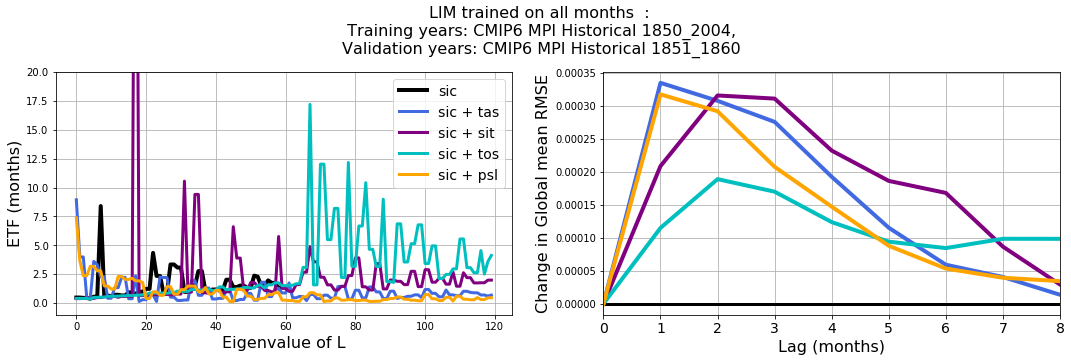

In [48]:
fig,axs = plt.subplots(1,2,figsize=(18,5))
ax = axs.flatten()

ax[0].plot(-1/(lam_L_baseline),label='sic',linewidth=4.0, color='k')
ax[1].axhline(0.0, color='k', linewidth=3, label='sic')

for n,limvars in enumerate(limvars_list[1:5]):
    var = 'sic'
    exp_name = "sic + "+(" + ").join(limvars[:-1])#+str(nmodes_sic)

    folder = 'historical/'
#     filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_'+
#                 (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)+'_20211018.pkl')
    filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_'+
                (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)+'_20211019.pkl')
    
    print('Loading '+folder+filename)

    experiment =  pickle.load(open(folder+filename, 'rb'))
    
    exp_setup = experiment['forecast']['exp_setup']
    forecast = experiment['forecast']
    LIMd = experiment['LIMd']
    forecast_validation = experiment['forecast_validation']
    forecast_validation_lags = experiment['forecast_validation_lags']
    ar1cast = experiment['ar1cast']
    ar1cast_lags = experiment['ar1cast_lags']
    
    [tcmip, vcmip, valid_yrs_str, texp, 
     vexp, tmod, vmod, wt_addin, tr_addin] = get_title_strings(var,exp_setup,forecast)
    
    rmse_diff = rmse_baseline - forecast_validation_lags['validation_stats_lags'][var]['gm_rmse']

    LIMd['lam_L']
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

    ax[0].plot(-(1/LIMd['lam_L']),label=(exp_name),linewidth=3.0, color=colors[n])
    ax[1].plot(exp_setup['lags'][:],rmse_diff,label=(exp_name),linewidth=4.0, color=colors[n])
    

ax[0].grid(axis='both')
ax[0].set_ylim(-1,20)

ax[1].set_xticklabels(np.arange(0,18,1),fontsize=14)
#ax[1].set_ylim(-0.00025,0.00025)
ax[1].set_xlim(0,8)
ax[1].grid(axis='both')
    
if exp_setup['Insamp']==True:     
    plt.suptitle(('LIM trained on all months:\n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else: 
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+': \n Training years: '+
                  tcmip+' '+tmod+' '+texp+' '+exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+
                  vcmip+' '+vmod+' '+vexp+' '+valid_yrs_str), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_xlabel('Eigenvalue of L', fontsize=16)
ax[0].set_ylabel('ETF (months)', fontsize=16)

ax[0].legend(loc='upper right', fontsize=14)
#ax[1].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)
ax[1].set_xlabel('Lag (months)', fontsize=16)
ax[1].set_ylabel('Change in Global mean RMSE', fontsize=16)

plt.subplots_adjust(top=0.8)

/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


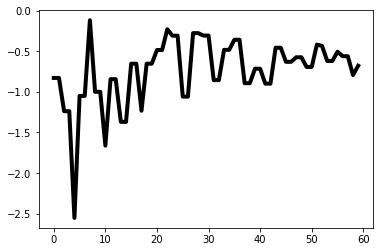

In [190]:
plt.plot(lam_L_baseline,label='sic',linewidth=4.0, color='k')
plt.show()